# Handwritten Number Identification
* Dataset Used : MNIST dataset from pytorch
* Multiclass classification model
> author : Ayush Ghodake
>
> github : ayu5h4


Dependencies

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
# device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_dataset = datasets.MNIST(
    root="data",
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
    train=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 474kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.76MB/s]


In [ ]:
test_dataset = datasets.MNIST(
    root="data",
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
    train=False
)

In [ ]:
train_dataset,test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [ ]:
img,label=train_dataset[10]

In [ ]:
img.shape,label

(torch.Size([1, 28, 28]), 3)

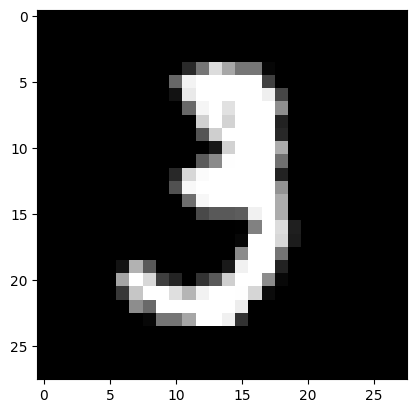

In [ ]:
plt.imshow(img.squeeze(),cmap="gray")

In [ ]:
class_names=train_dataset.classes

In [ ]:
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
# data is ready create dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
)
test_dataloader=DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=True
)

In [ ]:
# dataloaders with batch size of 1875 we have 313 batches for training set
len(train_dataloader)

1875

In [ ]:
# dataloaders with batch size of 32 we have 313 batches for testing set
len(test_dataloader)

313

#### For architecture of the model i will use tinyVgg
* you can check this out at : https://poloclub.github.io/cnn-explainer/

In [ ]:
# model
class MNIST_model_54(nn.Module):
  def __init__(self,
               in_shape:int,
               out_shape:int,
               hidden_units:int):
    super().__init__()
    self.stack_1=nn.Sequential(
        nn.Conv2d(
            in_channels=in_shape,
            out_channels=hidden_units,
            kernel_size=(3,3),
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=(3,2),
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=1
        )
    )
    self.stack_2=nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=1
        )
    )
    self.classification=nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=7020, #size of out vector after passing through flatten ()
            out_features=out_shape
        )
    )
  def forward(self,x):
    x=self.stack_1(x)
    x=self.stack_2(x)
    x=self.classification(x)
    return x

In [126]:
model=MNIST_model_54(
    in_shape=1,
    hidden_units=10,
    out_shape=len(class_names)
)

In [127]:
model

MNIST_model_54(
  (stack_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (stack_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7020, out_features=10, bias=True)
  )
)

In [ ]:
rand_img=torch.randn(size=(1,28,28))

In [ ]:
pred = model(img.unsqueeze(0))

In [ ]:
pred.argmax()

tensor(1)

In [ ]:
# to choose our loss function and optimizer
loss_fn=nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.1
)

In [ ]:
# training and testing loop
def train_model(model:torch.nn.Module,
                data_loader,
                loss_fn=loss_fn,
                optimizer=optimizer):
  train_loss = 0
  model.to(device)
  model.train()
  for batch ,(x,y) in enumerate(data_loader):
    x,y=x.to(device),y.to(device)
    y_preds=model(x)
    loss=loss_fn(y_preds,y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 300 == 0 :
      print(f"loss for batch {batch} = {loss}")
  train_loss/= len(data_loader)
  print(f"average data loss per epoch = {train_loss}")

def test_model(model:torch.nn.Module,
               data_loader,
               loss_fn=loss_fn):
  model.to(device)
  model.eval()
  with torch.inference_mode():
    test_loss=0
    for batch,(x,y) in enumerate(data_loader):
      x,y=x.to(device),y.to(device)
      y_preds=model(x)
      t_loss = loss_fn(y_preds,y)
      test_loss+=t_loss
      if batch % 300 == 0 :
        print(f"training loss for batch {batch} = {t_loss}")
    test_loss /= len(data_loader)

In [ ]:
# to train out model

epochs = 3
for epoch in range(epochs):
  train_model(
      model=model,
      data_loader=train_dataloader
  )
  test_model(
      model=model,
      data_loader=test_dataloader
  )


loss for batch 0 = 0.03378109633922577
loss for batch 300 = 0.008544323034584522
loss for batch 600 = 0.0023615597747266293
loss for batch 900 = 0.09533832222223282
loss for batch 1200 = 0.11062023043632507
loss for batch 1500 = 0.07364770025014877
loss for batch 1800 = 0.010120691731572151
average data loss per epoch = 0.056244272738695145
training loss for batch 0 = 0.019087808206677437
training loss for batch 300 = 0.008359403349459171
loss for batch 0 = 0.007552744820713997
loss for batch 300 = 0.0036176417488604784
loss for batch 600 = 0.019709788262844086
loss for batch 900 = 0.02530033327639103
loss for batch 1200 = 0.012884731404483318
loss for batch 1500 = 0.0036662353668361902
loss for batch 1800 = 0.07728345692157745
average data loss per epoch = 0.05034657195210457
training loss for batch 0 = 0.0018965690396726131
training loss for batch 300 = 0.025547586381435394
loss for batch 0 = 0.04463809356093407
loss for batch 300 = 0.021991288289427757
loss for batch 600 = 0.0809467

In [131]:
# display model on device if needed
print(f"Model on device:\n{next(model.parameters()).device}")

Model on device:
cpu


In [132]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model.pth


In [134]:
# Instantiate a fresh instance of LinearRegressionModelV2
# Load model state dict
model.load_state_dict(torch.load("/content/01_pytorch_workflow_model_0.pth", map_location=torch.device('cpu')))

print(f"Loaded model:\n{model}")
print(f"Model on device:\n{next(model.parameters())}")

Loaded model:
MNIST_model_54(
  (stack_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (stack_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7020, out_features=10, bias=True)
  )
)
Model on device:
Parameter containing:
tensor([[[[ 0.3178, -0.0969,  0.2284],
          [-0.2875,  0.2533, -0.0597],
          [ 0.1905, -0.0598, -0.3714]]],


        [[[-0.1793, -0.0884,  0.2056],
          [-0.2966, -0.3149, -0.1699],
          [-0.2240, -0.2034,  0.4687]]],


        [[[-0.2564, -0.4090, -0.7481],
          

In [128]:
model

MNIST_model_54(
  (stack_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (stack_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7020, out_features=10, bias=True)
  )
)

In [138]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [139]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
pred_probs= make_predictions(model=model,
                             data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2 (2 - two)


tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

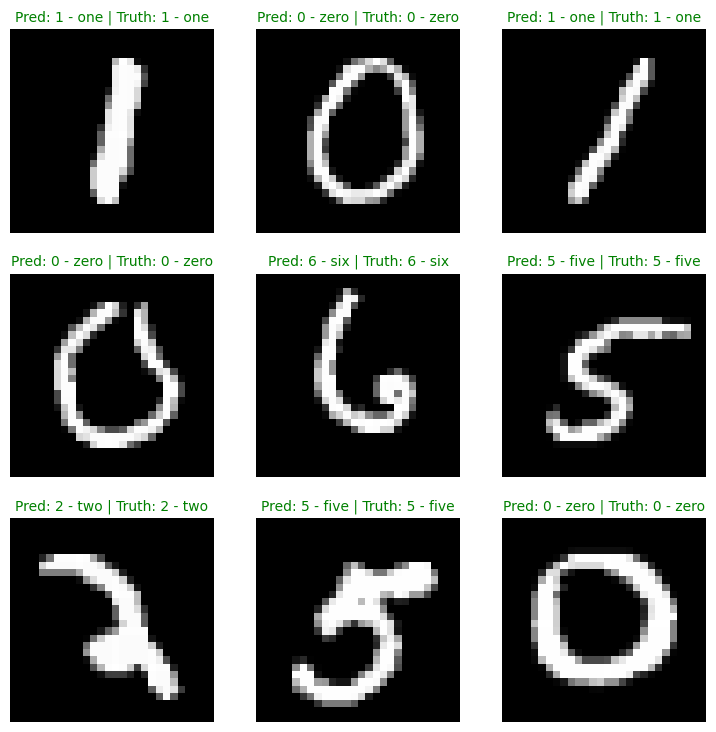

In [149]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs= make_predictions(model=model,
                             data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);